In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, a=1., b=1.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0
    # r_c = np.hypot(x_2d - x_c, y_2d - y_c)
    r_c = np.hypot((x_2d - x_c) / a, (y_2d - y_c) / b)
    
    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy()


In [3]:
def moca1(u, v, x, y, n_ic, n_jc, r=14):
    u1 = u[n_ic-r:n_ic+r+1, n_jc]
    v1 = v[n_ic-r:n_ic+r+1, n_jc]
    dx = x[1] - x[0]
    xx = x[n_ic-r:n_ic+r+1]
    yy = [y[n_jc]] * len(xx)
    l = xx - xx[0]
    coefficients = np.polyfit(l, v1, 1)
    c, b = coefficients
    a = np.polyfit(l, u1, 0)[0]
    x0 = - b / c
    y0 = a / c
    x0 += xx[0]
    y0 += yy[0]

    w = 2*c

    return x0, y0, l, xx, yy, u1, v1, a, b, c, w

In [4]:
X, Y = np.meshgrid(x, y)
nic, njc = 50, 60
r = 14

df_tests = pd.DataFrame({
    'nic': [nic, nic, nic, nic, nic, nic],
    'njc': [54, njc, 66, njc, njc, njc],
    'r': [r, r, r, 8, r, 20]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():

    x0_rel, y0_rel, l_rel, xx_rel, yy_rel, u1_rel, v1_rel, a_rel, b_rel, c_rel, w_rel = moca1(u, v, x, y, nic_rel, njc_rel, r_rel)

    dic_tests[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'l': l_rel, 'xx': xx_rel, 'yy': yy_rel,
        'u1': u1_rel, 'v1': v1_rel, 'a': a_rel, 'b': b_rel,
        'c': c_rel, 'w': w_rel, 'name': test_name
    }

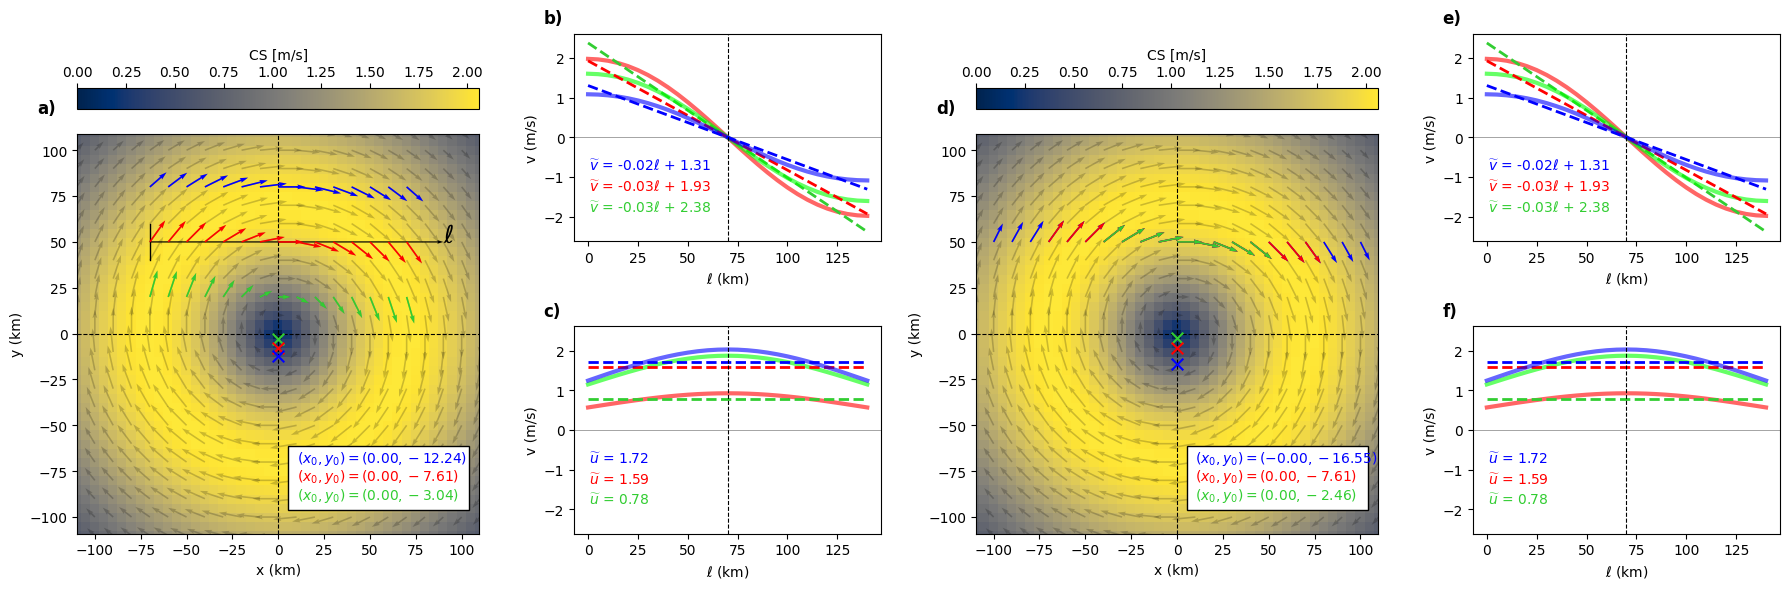

In [7]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 2, 1, 1, 2])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pc = ax_main_left.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(pc, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')
ax_main_left.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_left.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 30
width = 0.004
alpha = 1
quiv = ax_main_left.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

colors = ['limegreen', 'r', 'b']
i = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])
        if dic['name'] == 'P2':
            # l axis
            ax_main_left.quiver(xx[0], yy[0], xx[-1] - xx[0] + 20, yy[-1] - yy[0], angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=1)
            ax_main_left.plot([xx[0], xx[0]], [yy[0] - 10, yy[0] + 10], color='k', linewidth=1)
            ax_main_left.text(xx[-1] + 20, yy[0], r'$\ell$', fontsize=18)
        ax_main_left.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color=colors[i], zorder=3)
        ax_main_left.scatter(x0, y0, color=colors[i], marker='x', s=70, zorder=4)
        ax_main_left.text(10, -90 + 10*i, fr'$(x_0,y_0)=({dic["x0"]:.2f},{dic["y0"]:.2f})$', color=colors[i])
        i += 1
x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_left.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_left.add_patch(rect)
ax_main_left.axis('equal')
ax_main_left.set_xlim(-100, 100)
ax_main_left.set_ylim(-100, 100)
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.text(-0.1, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

color_fits = [(1, 0, 0, 0.6), (0, 1, 0, 0.6), (0, 0, 1, 0.6)]
color = ['g', 'r', 'b']
j = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])
        fit = np.poly1d(np.polyfit(l, v1, 1))
        ax2_left.plot(l, v1, color=color_fits[j], linewidth=3)
        ax2_left.plot(l, fit(l), color=colors[j], linestyle='--', linewidth=2) 
        ax2_left.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{v}}$ = {fit[1]:.2f}$\ell$ + {fit[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color=colors[j])

        fit = np.poly1d(np.polyfit(l, u1, 0))
        ax3_left.plot(l, u1, color=color_fits[j], linewidth=3)
        ax3_left.plot(l, fit(l), color=colors[j], linestyle='--', linewidth=2)
        ax3_left.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{u}}$ = {fit[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color=colors[j])

        j += 1

ymin1, ymax1 = ax2_left.get_ylim()
ymin2, ymax2 = ax3_left.get_ylim()
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)
ax2_left.set_ylim(ymin, ymax)
ax3_left.set_ylim(ymin, ymax)
ax2_left.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.set_ylabel('v (m/s)')
ax2_left.set_xlabel(r'$\ell$ (km)')
ax2_left.text(-0.1, 1.05, 'b)', transform=ax2_left.transAxes, fontsize=12, fontweight='bold')
ax3_left.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.set_ylabel('v (m/s)')
ax3_left.set_xlabel(r'$\ell$ (km)')
ax3_left.text(-0.1, 1.05, 'c)', transform=ax3_left.transAxes, fontsize=12, fontweight='bold')

# Right PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 3:5])
pc = ax_main_right.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(pc, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')
ax_main_right.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_right.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
quiv = ax_main_right.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

colors = ['limegreen', 'r', 'b']
i = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])
        ax_main_right.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color=colors[i], zorder=5-i)
        ax_main_right.scatter(x0, y0, color=colors[i], marker='x', s=70, zorder=4)
        ax_main_right.text(10, -90 + 10*i, fr'$(x_0,y_0)=({dic["x0"]:.2f},{dic["y0"]:.2f})$', color=colors[i])
 
        i += 1
x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_right.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_right.add_patch(rect)
ax_main_right.axis('equal')
ax_main_right.set_xlim(-100, 100)
ax_main_right.set_ylim(-100, 100)
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.text(-0.1, 1.05, 'd)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

color_fits = [(1, 0, 0, 0.6), (0, 1, 0, 0.6), (0, 0, 1, 0.6)]
color = ['g', 'r', 'b']
j = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])
        fit = np.poly1d(np.polyfit(l, v1, 1))
        ax2_right.plot(l, v1, color=color_fits[j], linewidth=3)
        ax2_right.plot(l, fit(l), color=colors[j], linestyle='--', linewidth=2) 
        ax2_right.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{v}}$ = {fit[1]:.2f}$\ell$ + {fit[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color=colors[j])

        fit = np.poly1d(np.polyfit(l, u1, 0))
        ax3_right.plot(l, u1, color=color_fits[j], linewidth=3)
        ax3_right.plot(l, fit(l), color=colors[j], linestyle='--', linewidth=2)
        ax3_right.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{u}}$ = {fit[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color=colors[j])

        j += 1

ymin1, ymax1 = ax2_right.get_ylim()
ymin2, ymax2 = ax3_right.get_ylim()
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)
ax2_right.set_ylim(ymin, ymax)
ax3_right.set_ylim(ymin, ymax)
ax2_right.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.set_ylabel('v (m/s)')
ax2_right.set_xlabel(r'$\ell$ (km)')
ax2_right.text(-0.1, 1.05, 'e)', transform=ax2_right.transAxes, fontsize=12, fontweight='bold')
ax3_right.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.set_ylabel('v (m/s)')
ax3_right.set_xlabel(r'$\ell$ (km)')
ax3_right.text(-0.1, 1.05, 'f)', transform=ax3_right.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [6]:
float(dic_tests['P1']['x0'])

1.4210854715202004e-14